In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
path = str(Path.cwd().parent)
print(path)
sys.path.insert(1, path)

import numpy as np
import pandas as pd
import skforecast

print(skforecast.__version__)

/home/joaquin/Documents/GitHub/skforecast
0.18.0


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Data manipulation
# ==============================================================================
import pandas as pd
import numpy as np
from skforecast.datasets import fetch_dataset

# Plotting
# ==============================================================================
import matplotlib.pyplot as plt
import shap
from skforecast.plot import set_dark_theme

# Modeling and forecasting
# ==============================================================================
import sklearn
import lightgbm
import skforecast
from sklearn.inspection import PartialDependenceDisplay
from lightgbm import LGBMRegressor
from skforecast.recursive import ForecasterRecursive
from skforecast.preprocessing import RollingFeatures
from skforecast.model_selection import backtesting_forecaster, TimeSeriesFold

color = '\033[1m\033[38;5;208m'
print(f"{color}Version skforecast: {skforecast.__version__}")
print(f"{color}Version scikit-learn: {sklearn.__version__}")
print(f"{color}Version lightgbm: {lightgbm.__version__}")
print(f"{color}Version shap: {shap.__version__}")


Version skforecast: 0.18.0
Version scikit-learn: 1.7.1
Version lightgbm: 4.5.0
Version shap: 0.47.2


In [4]:
# Download data
# ==============================================================================
data = fetch_dataset(name="vic_electricity")
data.head(3)
# Aggregation to daily frequency
# ==============================================================================
data = data.resample('D').agg({'Demand': 'sum', 'Temperature': 'mean'})
data.head(3)
# Create calendar variables
# ==============================================================================
data['day_of_week'] = data.index.dayofweek
data['month'] = data.index.month
data.head(3)
# Split train-test
# ==============================================================================
end_train = '2014-12-01 23:59:00'
data_train = data.loc[: end_train, :]
data_test  = data.loc[end_train:, :]
print(f"Dates train : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates test  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")
# Create a recursive multi-step forecaster (ForecasterRecursive)
# ==============================================================================
window_features = RollingFeatures(stats=['mean'], window_sizes=24)
exog_features = ['Temperature', 'day_of_week', 'month']
forecaster = ForecasterRecursive(
                 regressor       = LGBMRegressor(random_state=123, verbose=-1),
                 lags            = 7,
                 window_features = window_features
             )

forecaster.fit(
    y    = data_train['Demand'],
    exog = data_train[exog_features],
)

╭──────────────────────────── vic_electricity ─────────────────────────────╮
│ Description:                                                             │
│ Half-hourly electricity demand for Victoria, Australia                   │
│                                                                          │
│ Source:                                                                  │
│ O'Hara-Wild M, Hyndman R, Wang E, Godahewa R (2022).tsibbledata: Diverse │
│ Datasets for 'tsibble'. https://tsibbledata.tidyverts.org/,              │
│ https://github.com/tidyverts/tsibbledata/.                               │
│ https://tsibbledata.tidyverts.org/reference/vic_elec.html                │
│                                                                          │
│ URL:                                                                     │
│ https://raw.githubusercontent.com/skforecast/skforecast-                 │
│ datasets/main/data/vic_electricity.csv                                   │
│                                                                          │
│ Shape: 52608 rows x 4 columns                                            │
╰──────────────────────────────────────────────────────────────────────────╯

Dates train : 2011-12-31 00:00:00 --- 2014-12-01 00:00:00  (n=1067)
Dates test  : 2014-12-02 00:00:00 --- 2014-12-31 00:00:00  (n=30)


In [5]:
# Training matrices used by the forecaster to fit the internal regressor
# ==============================================================================
X_train, y_train = forecaster.create_train_X_y(
                       y    = data_train['Demand'],
                       exog = data_train[exog_features],
                   )

display(X_train.head(3)) # Features
display(y_train.head(3)) # Target

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,roll_mean_24,Temperature,day_of_week,month
Time,,,,,,,,,,,
2012-01-24,280188.298774,239810.374218,207949.859910,225035.325476,240187.677944,247722.494256,292458.685446,222658.202570,26.611458,1.0,1.0
2012-01-25,287474.816646,280188.298774,239810.374218,207949.859910,225035.325476,240187.677944,247722.494256,231197.497184,19.759375,2.0,1.0
2012-01-26,239083.684380,287474.816646,280188.298774,239810.374218,207949.859910,225035.325476,240187.677944,231668.556646,20.038542,3.0,1.0


Time
2012-01-24    287474.816646
2012-01-25    239083.684380
2012-01-26    214239.304588
Freq: D, Name: y, dtype: float64

In [6]:
# Create SHAP explainer (for three base models)
# ==============================================================================
explainer = shap.TreeExplainer(forecaster.regressor)

# Sample 50% of the data to speed up the calculation
rng = np.random.default_rng(seed=785412)
sample = rng.choice(X_train.index, size=int(len(X_train)*0.5), replace=False)
X_train_sample = X_train.loc[sample, :]
shap_values = explainer.shap_values(X_train_sample)

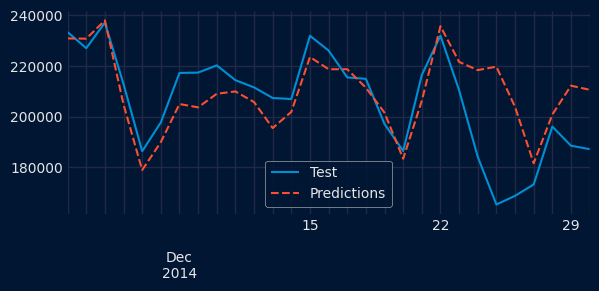

In [8]:
# Forecasting next 30 days
# ==============================================================================
predictions = forecaster.predict(steps=29, exog=data_test[exog_features])
set_dark_theme()
fig, ax = plt.subplots(figsize=(6, 2.5))
data_test.loc[predictions.index, 'Demand'].plot(ax=ax, label='Test')
predictions.plot(ax=ax, label='Predictions', linestyle='--')
ax.set_xlabel(None)
ax.legend();

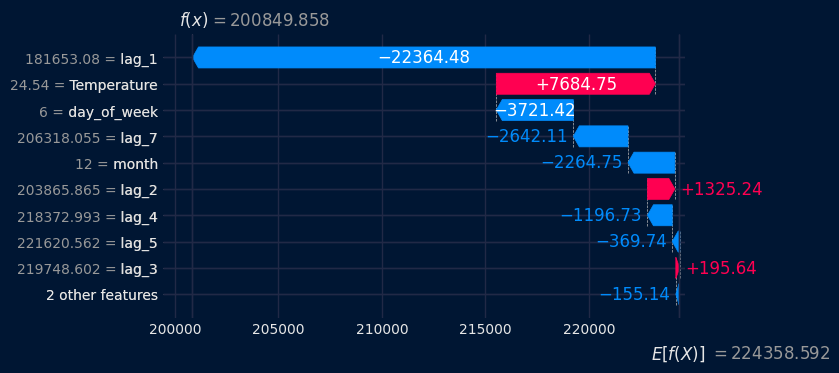

In [9]:
# Create input matrix used to forecast the next 30 steps
# ==============================================================================
X_predict = forecaster.create_predict_X(steps=29, exog=data_test[exog_features])
# SHAP values for the predictions
# ==============================================================================
shap_values = explainer.shap_values(X_predict)
# Waterfall plot for a single prediction
# ==============================================================================
predicted_date = '2014-12-28'
iloc_predicted_date = X_predict.index.get_loc(predicted_date)
shap_values_single = explainer(X_predict)
shap.plots.waterfall(shap_values_single[iloc_predicted_date], show=False)
fig, ax = plt.gcf(), plt.gca()
fig.set_size_inches(6, 3.5)
ax_list = fig.axes
ax = ax_list[0]
ax.tick_params(labelsize=10)
plt.show()


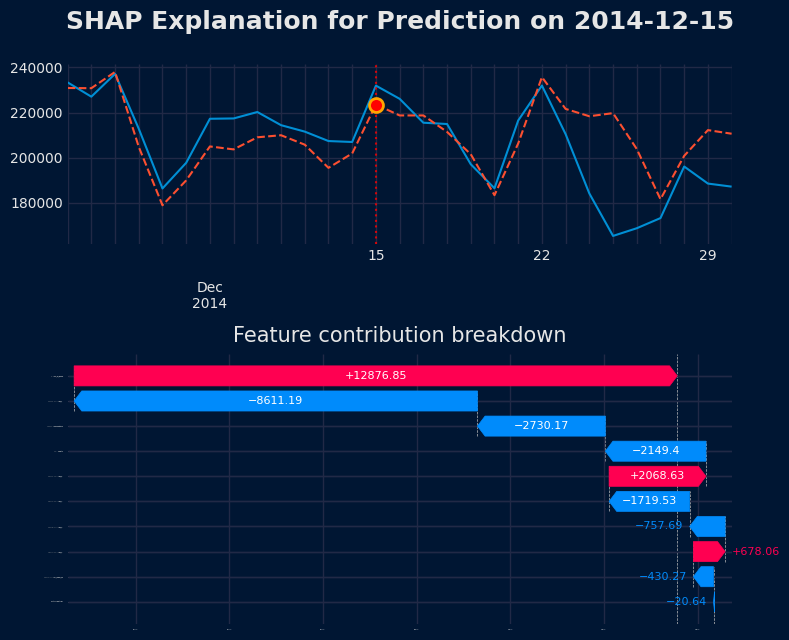

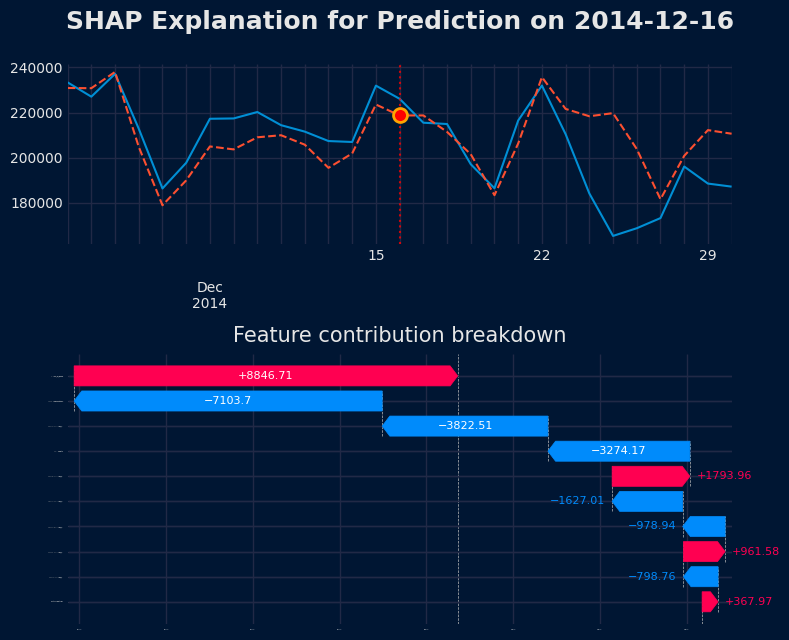

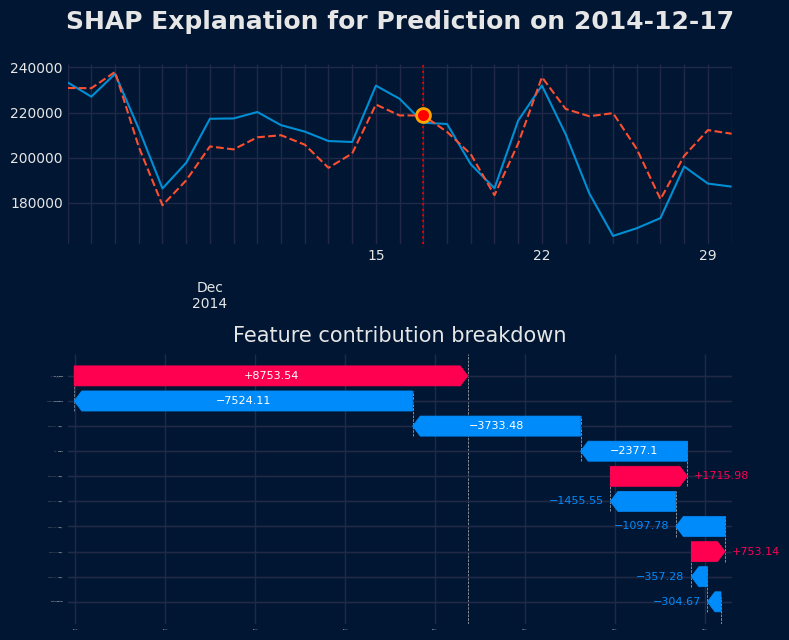

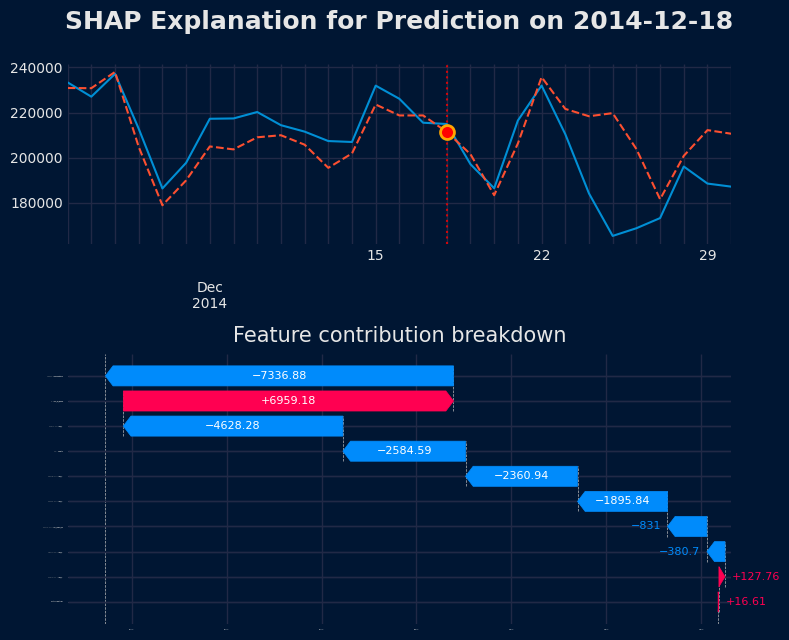

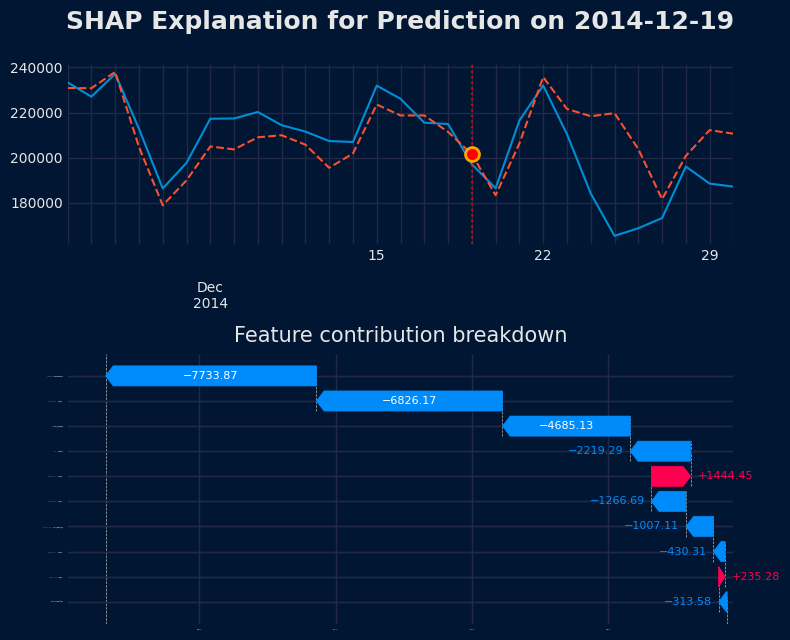

In [17]:
dates = ['2014-12-15', '2014-12-16', '2014-12-17',
               '2014-12-18', '2014-12-19']

for date in dates:
    fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(14, 9), gridspec_kw={'height_ratios': [2, 3]})

    # Plot predictions and test data
    data_test.loc[predictions.index, 'Demand'].plot(ax=axs[0], label='Test')
    predictions.plot(ax=axs[0], label='Predictions', linestyle='--')
    axs[0].set_xlabel(None)
    

    # Higlight date being explained with a pointer circle
    axs[0].axvline(pd.to_datetime(date), color='red', linestyle=':', linewidth=1.5, alpha=0.8)
    axs[0].scatter(pd.to_datetime(date), predictions.loc[date], color='red', s=100, marker='o', edgecolors='orange', linewidths=2, zorder=5)

    axs[0].set_title(f'SHAP Explanation for Prediction on {date}', fontsize=18, pad=25, fontweight='semibold')
    
    # SHAP waterfall plot
    iloc_date = X_predict.index.get_loc(date)
    shap_values_single = explainer(X_predict)
    shap.plots.waterfall(shap_values_single[iloc_date], show=False)
    axs[1].tick_params(labelsize=0)
    axs[1].set_title("Feature contribution breakdown", fontsize=15, pad=8)
    for text in axs[1].texts:
        # reduce font size of all texts
        text.set_fontsize(8)
    for a in fig.axes:
        texts = [t.get_text() for t in a.get_xticklabels()]
        if any(("f(x)" in t or "$f(x)$" in t or "E[f(X)]" in t or "$E[f(X)]$" in t) for t in texts):
            a.set_xticks([])            # remove ticks
            a.set_xticklabels([])       # remove tick labels
            # optionally hide spines/ticks for cleanliness
            for sp in ("top", "right", "left"):
                try:
                    a.spines[sp].set_visible(False)
                except Exception:
                    pass
            a.xaxis.set_ticks_position("none")

    plt.tight_layout()
    plt.show();

In [31]:
"""
Create animated GIF and MP4 video showing SHAP explanations for time series predictions.

This code generates a sequence of plots for different prediction dates, each showing:
- Time series predictions with highlighted date
- SHAP waterfall plot explaining feature contributions

The animation helps visualize how feature importance changes over time.
"""

import os
from PIL import Image
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

try:
    import imageio
except ImportError:
    print("imageio not installed. Install with: pip install imageio")
    raise

# Configuration
dates = ['2014-12-15', '2014-12-16', '2014-12-17', '2014-12-18', '2014-12-19']
fps = 1  # frames per second for video
gif_duration = 1000  # milliseconds per frame for GIF
output_width = 900  # width for resized frames

def create_frame(date):
    """
    Create a single frame for the animation showing SHAP explanation for a specific date.

    Parameters:
    - date: str, date string for the prediction to explain

    Returns:
    - PIL Image: resized frame ready for animation
    """
    fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(14, 9),
                            gridspec_kw={'height_ratios': [2, 3]})

    # Plot time series predictions
    data_test.loc[predictions.index, 'Demand'].plot(ax=axs[0], label='Test')
    predictions.plot(ax=axs[0], label='Predictions', linestyle='--')
    axs[0].set_xlabel(None)

    # Highlight the explained date
    axs[0].axvline(pd.to_datetime(date), color='red', linestyle=':', linewidth=1.5, alpha=0.8)
    axs[0].scatter(pd.to_datetime(date), predictions.loc[date], color='red',
                   s=100, marker='o', edgecolors='orange', linewidths=2, zorder=5)
    axs[0].set_title(f'SHAP Explanation for Prediction on {date}',
                     fontsize=18, pad=25, fontweight='semibold')

    # SHAP waterfall plot
    iloc_date = X_predict.index.get_loc(date)
    shap_values_single = explainer(X_predict)
    shap.plots.waterfall(shap_values_single[iloc_date], show=False)
    axs[1].tick_params(labelsize=0)
    axs[1].set_title("Feature contribution breakdown", fontsize=15, pad=8)

    # Clean up SHAP plot text and axes
    for text in axs[1].texts:
        text.set_fontsize(8)
    for a in fig.axes:
        texts = [t.get_text() for t in a.get_xticklabels()]
        if any(("f(x)" in t or "$f(x)$" in t or "E[f(X)]" in t or "$E[f(X)]$" in t) for t in texts):
            a.set_xticks([])
            a.set_xticklabels([])
            for sp in ("top", "right", "left"):
                try:
                    a.spines[sp].set_visible(False)
                except Exception:
                    pass
            a.xaxis.set_ticks_position("none")

    plt.tight_layout()

    # Save temporarily and load as PIL Image
    filename = f"temp_{date}.png"
    fig.savefig(filename, dpi=120, bbox_inches='tight')
    plt.close(fig)

    img = Image.open(filename)
    img = img.resize((output_width, int(output_width * img.height / img.width)))

    # Clean up temporary file
    os.remove(filename)

    return img

# Generate frames
print("Generating animation frames...")
frames = [create_frame(date) for date in dates]
print(f"Created {len(frames)} frames")

# Save optimized GIF
print("Saving GIF...")
frames[0].save('skforecast_shap_explanability.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=gif_duration,
               loop=0,
               optimize=True)

# Save as MP4 video
print("Saving MP4 video...")
imageio.mimsave('skforecast_shap_explanability.mp4',
                [np.array(img) for img in frames], fps=fps)

print("✅ Animation files created successfully!")
print("📁 skforecast_shap_explanability.gif")
print("🎥 skforecast_shap_explanability.mp4")

Generating animation frames...
Created 5 frames
Saving GIF...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (900, 728) to (912, 736) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Saving MP4 video...


[rawvideo @ 0x18e13000] Stream #0: not enough frames to estimate rate; consider increasing probesize


✅ Animation files created successfully!
📁 skforecast_shap_explanability.gif
🎥 skforecast_shap_explanability.mp4
